In [1]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import MumpsSolver
%pylab inline

Trouble importing matplotlib.
Populating the interactive namespace from numpy and matplotlib


In [2]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
sigma = mesh.readModelUBC("VTKout_DC.dat")

In [3]:
from ipywidgets import interact, IntSlider
def viz(sigma, ind, normal="Z"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5, 5)
    else:
        figsize(5, 2.5)

#     print mesh.vectorCCz[ind]
    temp = sigma.copy()
    temp[airind] = np.nan
    mesh.plotSlice(np.log10(sigma), ind=ind, clim=(-4, -1), normal=normal, grid=True)
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-600, 0.)      

In [4]:
def vizeta(eta, ind, normal="Z"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5, 5)
    else:
        figsize(5, 2.5)

#     print mesh.vectorCCz[ind]
    temp = eta.copy()
    temp[airind] = np.nan
    mesh.plotSlice(eta, ind=ind, normal=normal, grid=True)
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-600, 0.)      

In [5]:
def vizdata(data, src, rx, rxcomponent="X", clim=None):
    figsize(5,5)
    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()        
    else:
        X = Xy.copy()
        Y = Yy.copy()      
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        plt.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax)
    else:
        plt.contourf(X, Y, temp, 20)

In [6]:
def gettopoCC(mesh, airind):
# def gettopoCC(mesh, airind):
    """
        Get topography from active indices of mesh.
    """
    mesh2D = Mesh.TensorMesh([mesh.hx, mesh.hy], mesh.x0[:2])
    zc = mesh.gridCC[:,2]
    AIRIND = airind.reshape((mesh.vnC[0]*mesh.vnC[1],mesh.vnC[2]), order='F')
    ZC = zc.reshape((mesh.vnC[0]*mesh.vnC[1], mesh.vnC[2]), order='F')
    topo = np.zeros(ZC.shape[0])
    topoCC = np.zeros(ZC.shape[0])
    for i in range(ZC.shape[0]):
        ind  = np.argmax(ZC[i,:][~AIRIND[i,:]])
        topo[i] = ZC[i,:][~AIRIND[i,:]].max() + mesh.hz[~AIRIND[i,:]][ind]*0.5
        topoCC[i] = ZC[i,:][~AIRIND[i,:]].max()
    XY = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
    return mesh2D, topoCC

In [7]:
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)

In [8]:
Aloc0 = np.r_[-800., 0, 0.]
Bloc0 = np.r_[800., 0, 0.]
Aloc1 = np.r_[-600., 0, 0.]
Bloc1 = np.r_[600., 0, 0.]
Aloc2 = np.r_[-350., 0, 0.]
Bloc2 = np.r_[350., 0, 0.]

In [9]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300., mesh.vectorCCx<300.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300., mesh.vectorCCy<300.)]

In [10]:
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
My = Utils.ndgrid(x, y[:-1], np.r_[-12.5/2.])
Ny = Utils.ndgrid(x, y[1:], np.r_[-12.5/2.])

In [11]:
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
inds_My = Utils.closestPoints(mesh2D, My[:,:2])
inds_Ny = Utils.closestPoints(mesh2D, Ny[:,:2])

In [12]:
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]
My_dr = np.c_[My[:,0], My[:,1], topoCC[inds_My]]
Ny_dr = np.c_[Ny[:,0], Ny[:,1], topoCC[inds_Ny]]

(-1000, 1000)

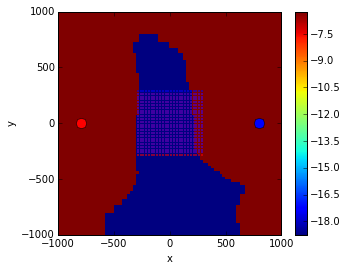

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
ax.plot(Aloc0[0], Aloc0[1], 'ro', ms=10)
ax.plot(Bloc0[0], Bloc0[1], 'bo', ms=10)
# ax.plot(Mx[:,0], Mx[:,1], 'r.', ms=2)
# ax.plot(Nx[:,0], Nx[:,1], 'b.')
ax.plot(My[:,0], My[:,1], 'r.', ms=2)
ax.plot(Ny[:,0], Ny[:,1], 'b.', ms=2)
dat = mesh2D.plotImage(topoCC, ax=ax)
plt.colorbar(dat[0])
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)


In [14]:
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
rx_y = DC.Rx.Dipole(My_dr, Ny_dr)
src0 = DC.Src.Dipole([rx_x, rx_y], Aloc0, Bloc0)
src1 = DC.Src.Dipole([rx_x, rx_y], Aloc1, Bloc1)
src2 = DC.Src.Dipole([rx_x, rx_y], Aloc2, Bloc2)

In [15]:
expmap = Maps.ExpMap(mesh)
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap

In [16]:
m0 = np.ones_like(sigma)[~airind]*np.log(1e-4)

In [17]:
survey = DC.Survey([src0, src1, src2])
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigma)[~airind]
f = problem.fields(mtrue)
dobs = survey.dpred(mtrue, f=f)

In [18]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")
Xy = My[:,0].reshape((24, 23), order="F")
Yy = 0.5*(My[:,1]+Ny[:,1]).reshape((24, 23), order="F")

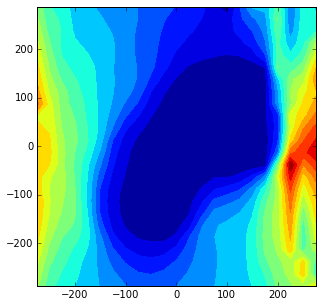

In [19]:
vizdata(dcdata, src0, rx_x, rxcomponent="X")

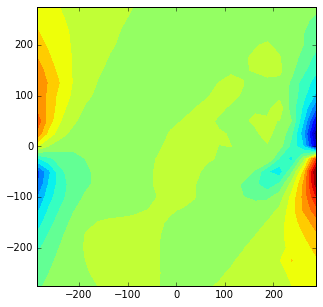

In [20]:
vizdata(dcdata, src2, rx_y, rxcomponent="Y")

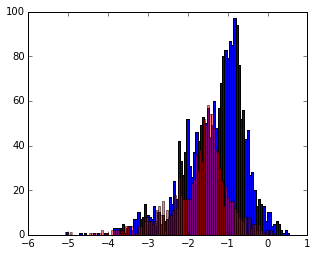

In [21]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
a = ax.hist(np.log10(dobs[dobs>0.]), bins=100)
b = ax.hist(np.log10(-dobs[dobs<0.]), bins=100, color='r', alpha=0.5)

In [22]:
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()

(-600, 0.0)

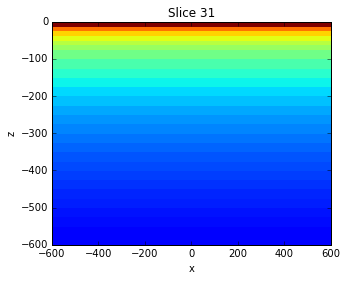

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
mesh.plotSlice(np.log10(depth), normal="Y", streamOpts={'color':'w'}, ax=ax)
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 0.)    

In [24]:
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
regmap = Maps.IdentityMap(nP=m0.size)
std = 0.05
eps = 1e-3
survey.std = std
survey.eps = eps
#TODO put warning when dobs is not set!
survey.dobs = dobs
dmisfit = DataMisfit.l2_DataMisfit(survey)
reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
reg.wght = depth[~airind]
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
reg.alpha_s = 1e-4
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)
sigopt = mapping*mopt
np.save("sigest", sigopt)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2016-05-04-11-39.txt'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.18e-01  1.53e+07  0.00e+00  1.53e+07    1.06e+06      0              
   1  2.18e-01  2.09e+06  3.54e+03  2.09e+06    1.52e+05      0              
   2  4.37e-02  2.18e+05  6.76e+04  2.21e+05    2.76e+04      0   Skip BFGS  
   3  4.37e-02  4.39e+04  2.08e+05  5.29e+04    5.61e+03      0   Skip BFGS  
   4  8.73e-03  1.64e+04  2.77e+05  1.88e+04    3.52e+03      0   Skip BFGS  
   5  8.73e-03  9.01e+03  3.32e+05  1.19e+04    2.46e+03    

In [26]:
# sigopt = np.load("sigest.npy")
sigopt = mapping*mopt

In [29]:
from SimPEG import Survey
datapred = invProb.dpred
obsdata = Survey.Data(survey, v=dobs)
preddata = Survey.Data(survey, v=datapred)

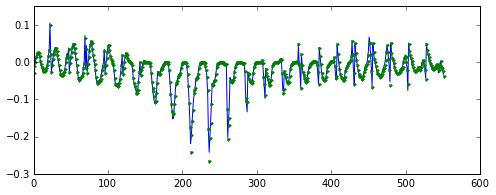

In [31]:
figsize(8,3)
plt.plot(obsdata[src1, rx_y])
plt.plot(preddata[src1, rx_y], '.')

<function __main__.<lambda>>

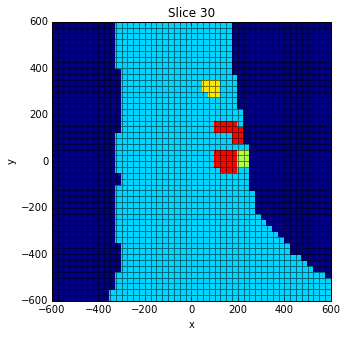

In [32]:
interact(lambda ind: viz(sigma, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

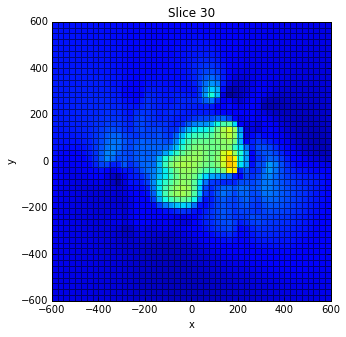

In [33]:
interact(lambda ind: viz(sigopt, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

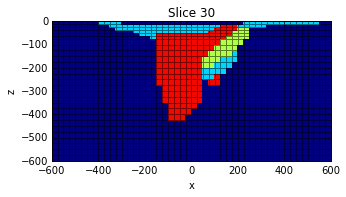

In [34]:
interact(lambda ind: viz(sigma, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

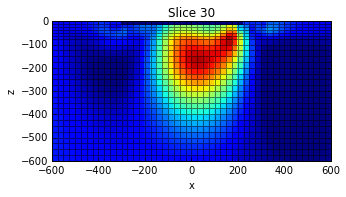

In [35]:
interact(lambda ind: viz(sigopt, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

In [36]:
eta = mesh.readModelUBC("VTKout_eta.dat")
actmapIP = Maps.InjectActiveCells(mesh, ~airind, 0.)
problemIP = IP.Problem3D_CC(mesh, rho=1./sigma, Ainv=problem.Ainv, f=f, mapping=actmapIP)
problemIP.Solver = MumpsSolver
surveyIP = IP.Survey([src0, src1, src2])
problemIP.pair(surveyIP)
dataIP = surveyIP.dpred(eta[~airind])

In [37]:
survey = DC.Survey([src0, src1, src2])
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigopt)[~airind]
f = problem.fields(mtrue)
problemIP = IP.Problem3D_CC(mesh, rho=1./sigopt, Ainv=problem.Ainv, f=f, mapping=actmapIP)
problemIP.Solver = MumpsSolver
surveyIP = IP.Survey([src0, src1, src2])
problemIP.pair(surveyIP)

In [38]:
# interact(lambda ind: viz(eta, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

In [39]:
ipdata = Survey.Data(surveyIP, v=dataIP)

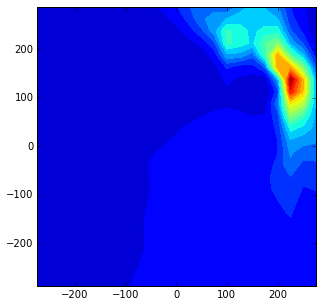

In [40]:
vizdata(ipdata, src0, rx_x)

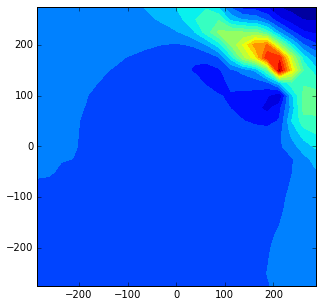

In [41]:
vizdata(ipdata, src0, rx_y, rxcomponent="Y")

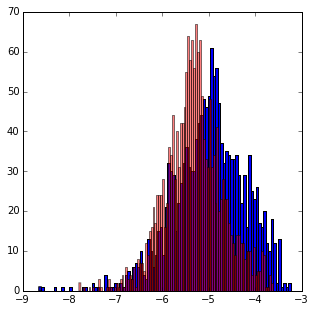

In [43]:
a = hist(np.log10(dataIP[dataIP>0.]), bins=100)
b = hist(np.log10(-dataIP[dataIP<0.]), bins=100, color='r', alpha=0.5)

In [ ]:
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
regmap = Maps.IdentityMap(nP=m0.size)
std = 0.
eps = 10**(-6)
surveyIP.std = std
surveyIP.eps = eps
m0 = np.ones(mesh.nC)[~airind]*1e-10
#TODO put warning when dobs is not set!
surveyIP.dobs = dataIP
dmisfit = DataMisfit.l2_DataMisfit(surveyIP)
reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
reg.wght = np.ones_like(depth[~airind])
opt = Optimization.ProjectedGNCG(maxIter = 20)
opt.lower = 0.
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=8, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10**1.5)
save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, save, target])
reg.alpha_s = 1e-2
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
problemIP.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mIPopt = inv.run(m0)
problemIP.Ainv.clean()

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2016-05-04-14-41.txt'
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  5.14e+05  4.76e+06  0.00e+00  4.76e+06    5.14e+08      0              


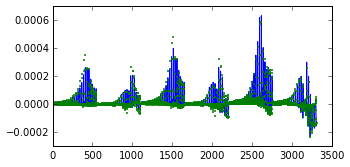

In [55]:
plt.plot(invProb.dpred)
plt.plot(surveyIP.dobs, '.', ms=3)

In [56]:
ippred = Survey.Data(surveyIP, v=invProb.dpred)
ippred_x = ippred[src0, rx_x]
ippred_y = ippred[src0, rx_y]
ip_x = ipdata[src0, rx_x]
ip_y = ipdata[src0, rx_y]
IPpredx = ippred_x.reshape((23, 24), order="F")
IPpredy = ippred_y.reshape((24, 23), order="F")
IPx = ip_x.reshape((23, 24), order="F")
IPy = ip_y.reshape((24, 23), order="F")

<matplotlib.contour.QuadContourSet instance at 0x11bf9a170>

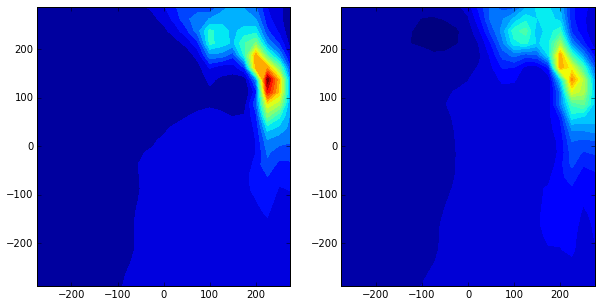

In [57]:
plt.figure(figsize=(10,5))
ax0 = plt.subplot(121)
ax0.contourf(Xx, Yx, IPx, 20, vmin=IPx.min(), vmax=IPx.max(), clim=(IPx.min(), IPx.max()))
ax1 = plt.subplot(122)
ax1.contourf(Xx, Yx, IPpredx, 20, vmin=IPx.min(), vmax=IPx.max(), clim=(IPx.min(), IPx.max()))

<matplotlib.contour.QuadContourSet instance at 0x1182e1290>

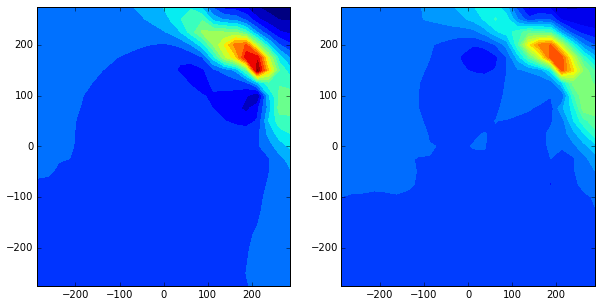

In [58]:
plt.figure(figsize=(10,5))
ax0 = plt.subplot(121)
ax0.contourf(Xy, Yy, IPy, 20, vmin=IPy.min(), vmax=IPy.max(), clim=(IPy.min(), IPy.max()))
ax1 = plt.subplot(122)
ax1.contourf(Xy, Yy, IPpredy, 20, vmin=IPy.min(), vmax=IPy.max(), clim=(IPy.min(), IPy.max()))

In [59]:
xc = opt.recall('xc')

In [60]:
temp = eta.copy()*np.nan
temp[eta==0.05]=0.05

<function __main__.<lambda>>

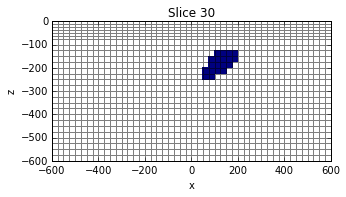

In [61]:
interact(lambda ind: vizeta(temp, ind, normal="Y"), ind=IntSlider(min=0, max=40,step=1, value=30))

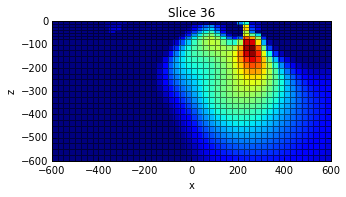

In [63]:
interact(lambda ind: vizeta(actmapIP*xc[6], ind, normal="Y"), ind=IntSlider(min=0, max=40,step=1, value=30))

(-600, 0.0)

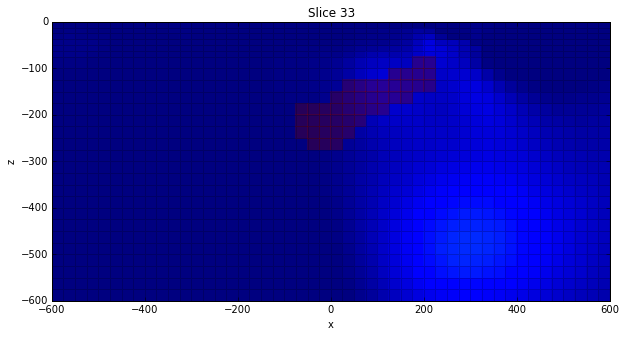

In [59]:
plt.figure(figsize=(5*2, 2.5*2))
ax = plt.subplot(111)
mesh.plotSlice(actmapIP*xc[4], normal="Y", streamOpts={'color':'w'}, gridOpts={'color':'k', 'alpha':0.1}, grid=True, ind=33, clim=(0, 0.02),ax=ax)
mesh.plotSlice(temp, normal="Y", streamOpts={'color':'w'}, gridOpts={'color':'k', 'alpha':0.1}, grid=True, ind=33, clim=(0, 0.05),ax=ax, pcolorOpts={'cmap':'jet', 'alpha':0.3})
xlim(-600, 600)
ylim(-600, 0.)    

(-600, 600.0)

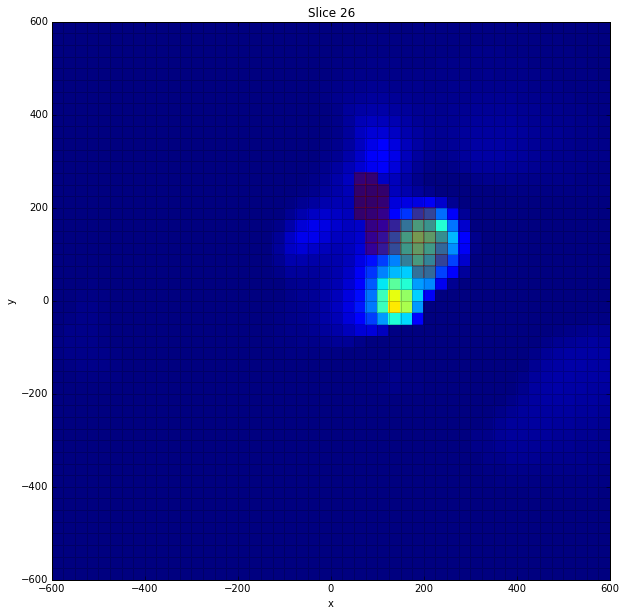

In [126]:
plt.figure(figsize=(5*2, 5*2))
ax = plt.subplot(111)
indz=26
mesh.plotSlice(actmapIP*xc[9], normal="Z", streamOpts={'color':'w'}, gridOpts={'color':'k', 'alpha':0.1}, grid=True, ind=indz, clim=(0, 0.03),ax=ax)
mesh.plotSlice(temp, normal="Z", streamOpts={'color':'w'}, gridOpts={'color':'k', 'alpha':0.1}, grid=True, ind=indz, clim=(0, 0.05),ax=ax, pcolorOpts={'cmap':'jet', 'alpha':0.4})
xlim(-600, 600)
ylim(-600, 600.)    

In [201]:
temp = np.zeros(mesh.nC)
temp[airind] = np.nan
temp[~airind] = xc[13]
mesh.writeVTK("charg", {"eta":eta, "etaest":actmapIP*xc[13]})